# Aula 2: FineTuning Eficiente de Modelos de Linguagem

Nesse notebook veremos exemplos e fundamentos patra o finetuning (ajuste fino) de modelos de linguagem para aumentar o desenpenho e adaptá-los à tarefas específicas.

Para isso, vamos utilizar um SLM, o Smol 360M, além da biblioteca PEFT do HuggingFace para fazer o o ajuste de maneira mais eficiente, economizando recursos computacionais.

O foco dessa aula será no treinamento de Adapters com a téninca LoRA: [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

### Instalando e importando bibliotecas:

In [ ]:
!pip install datasets --quiet
!pip install peft --quiet
!pip install trl --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import os
from tqdm import tqdm
import json
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Definindo funções úteis

In [ ]:
def load_model_and_tokenizer(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

Para colocar o LoRA monualmente nos modelos, sem a utilização de bibliotecas prontas. Faremos esse teste alterando diretemente o modelo do pytorch:

In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, orig_linear: nn.Linear, r: int = 8, alpha: float = 16):
        super().__init__()

        self.orig_linear = orig_linear
        self.r = r
        self.alpha = alpha
        # Criando os Adapters: A (out_features x r) and B (r x in_features), onde r será o rank intermediário
        self.lora_A = nn.Parameter(torch.zeros(orig_linear.out_features, r))
        self.lora_B = nn.Parameter(torch.zeros(r, orig_linear.in_features))
        # Inicializando: usando Kaiming-uniform para a matriz A e zeros para a matriz B. Dessa forma, no inicio não ocorre mudanças no modelo.
        #nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        #with normal
        nn.init.normal_(self.lora_A)
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        # Compute original output plus LoRA adjustment.
        # F.linear computes x @ weight.T + bias.
        lora_update = F.linear(x, self.lora_A @ self.lora_B)
        return self.orig_linear(x) + self.alpha * lora_update

def add_lora_to_model(model: nn.Module, r: int = 8, alpha: float = 16, target_module_names=None):

    if target_module_names is None: #Colocaremos adapters apenas nas camadas com esses nome.
        target_module_names = ['q_proj', 'k_proj', 'v_proj']

    for name, module in model.named_children():
        # Recursively process children modules.
        add_lora_to_model(module, r, alpha, target_module_names)

        # Troca apara a camada do LoRA quando o nome da camada é igual a algum dos target_module_names
        if isinstance(module, nn.Linear) and any(t in name for t in target_module_names):
            setattr(model, name, LoRALinear(module, r=r, alpha=alpha))

    return model

E uma função que prepara o modelo com o LoRA para treinamento. Depois de adicionar os adapters, congelamos todas as camadas com excessão das matriz do LoRA.

In [ ]:
def prepare_model_for_lora(model):

    for param in model.parameters():
        param.requires_grad = False

    for module in model.modules():
        if isinstance(module, LoRALinear):
            module.lora_A.requires_grad = True
            module.lora_B.requires_grad = True

E uma função de treinamento com pytorch para ajudtar as novas metrizes criadas e inseridas no modelo.

Nesse caso ainda criamos uma função de collate_fn, que prepara os dados para considerar os prompts inteiros (inputs) mas apenas calcular a loss para as respostas esperadas do modelo. Isso auxilia na convergência do modelo um vez que ele aprende apenas a responder aquela requisição.

In [ ]:
def train_lora_model(model, tokenizer, dataset, epochs=3, batch_size=1, learning_rate=5e-5, device='cuda', max_steps = 700):
    model.train()  # Modo de treinamento
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Vamos usar só o treino
    train_dataset = dataset["train"]

    # TEsse marker vai auxiliar a identificar one terimna a pergunta (prompt) e começa a resposta esperada
    marker = "### Response:\n"
    marker_ids = tokenizer(marker, add_special_tokens=False)["input_ids"]

    # Modificando as entradas para treinar apenas a parte de resposta
    def collate_fn(batch):
        texts = [item["Text"] for item in batch]
        encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device) #tokenização
        # Nossas labels a princípio são iguais as entradas
        encodings["labels"] = encodings["input_ids"].clone()

        # Maskaramento das respostas
        for i in range(encodings["input_ids"].size(0)):
            sequence = encodings["input_ids"][i].tolist()
            marker_len = len(marker_ids)
            start_idx = -1
            # Procura pelo marker na resposta
            for j in range(len(sequence) - marker_len + 1):
                if sequence[j:j+marker_len] == marker_ids:
                    start_idx = j + marker_len
                    break
            # Quando encontra, substitui a parte da pergunta por -100. Isso serve para a loss não ser computada nesses tokens.
            if start_idx > 0:
                encodings["labels"][i, :start_idx] = -100
        return encodings

    #Criando um dataloader do Pytorch para treinamento por batches
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    losses = []
    #E passamos pelo dataset fazendo um treinamento padrão de modelo (apenas nas caamadas LoRA não congeladas)
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(input_ids=batch["input_ids"], labels=batch["labels"])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            if step % 100 == 0:
                print(f"Epoch {epoch} Step {step} Loss {loss.item():.4f}")
            losses.append(loss.item())
            if step > max_steps:
                break

    return model, losses

Adicionalmente, uma função simples de inferência com os modelos que serão ajustados:

In [ ]:
def model_inference(model, tokenizer, prompt, max_new_tokens=100):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

E funções auxiliares de manipulação dos adapters:

In [ ]:
def get_lora_adapters(model):
    lora_params = []
    for module in model.modules():
        if isinstance(module, LoRALinear):
            lora_params.append((module.lora_A, module.lora_B))
    return lora_params

def set_lora_adapters(model, lora_params):
    for module in model.modules():
        if isinstance(module, LoRALinear):
            module.lora_A, module.lora_B = lora_params.pop(0)
    return model

In [ ]:
torch.cuda.empty_cache()

### Primeiro Exemplo: Ajuste para Geração de SQL apartir de texto

Utilizaremos a função a seguir para formatar todos os prompts no mesmo padrão que queremos para treinar o modelo nessa nova tarefa.

É importante deixar o marker igual ao definido anteriormente, para um treinamento apenas nas respostas:

In [ ]:
def sql_format_func(example):
    example["Text"] = f"### SQL Prompt:\n{example['sql_prompt']}\n### Response:\n{example['sql']}"
    return example

In [ ]:
dataset = load_dataset("gretelai/synthetic_text_to_sql")
dataset = dataset.map(lambda x: sql_format_func(x))

README.md:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

(…)nthetic_text_to_sql_train.snappy.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

(…)ynthetic_text_to_sql_test.snappy.parquet:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
model_name = 'HuggingFaceTB/SmolLM-360M'

model, tokenizer = load_model_and_tokenizer(model_name) #carregamos o modelo
model.to('cuda')

model = add_lora_to_model(model, r=8, alpha=16) #criamos as camadas lora
prepare_model_for_lora(model) #congelamos as demais camadas

Vamos ver de perto os adapters adicionados:

In [ ]:
#LoRA A
get_lora_adapters(model)[0][0]

Parameter containing:
tensor([[ 7.0502e-01, -1.9855e+00,  2.2184e-01,  ..., -2.0138e+00,
          5.8240e-01, -1.5436e-03],
        [-4.0647e-01, -1.4510e+00, -1.4875e-01,  ..., -6.5015e-01,
          9.6796e-01,  4.3772e-01],
        [-3.3404e-01,  1.1281e+00,  1.6775e+00,  ...,  1.5362e+00,
         -2.9540e-01, -1.1009e+00],
        ...,
        [ 2.6551e-01, -5.8372e-01,  1.0082e+00,  ..., -8.3769e-02,
         -8.1879e-01,  1.4688e+00],
        [ 6.2362e-01, -1.2580e+00, -8.8351e-01,  ..., -1.4645e+00,
          1.4056e+00,  3.4007e-01],
        [ 2.0709e+00, -1.3046e+00, -2.9634e-01,  ..., -3.8894e-02,
          8.5916e-01, -3.5117e-01]], requires_grad=True)

In [ ]:
get_lora_adapters(model)[0][0].shape

torch.Size([960, 8])

In [ ]:
A_params = []
for param in get_lora_adapters(model)[0][0]:
    A_params.append(param)

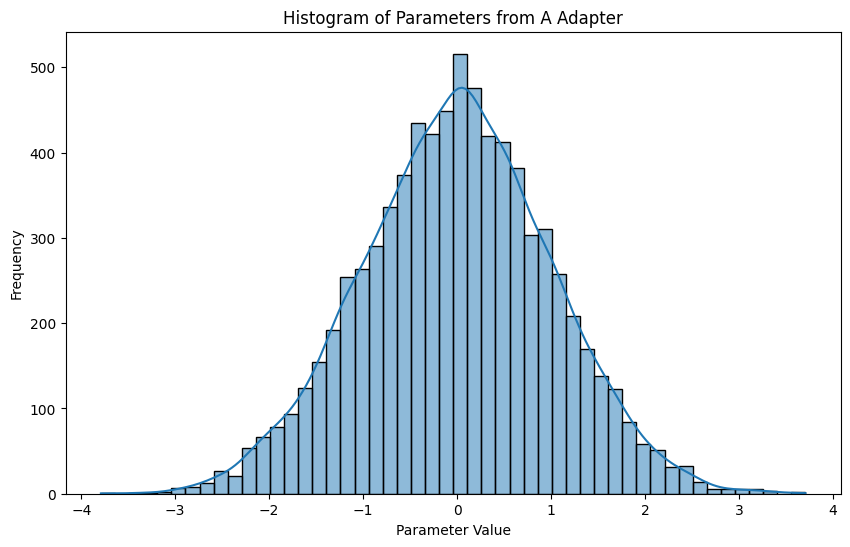

In [ ]:
A_params_flat = []
for param in A_params:
  A_params_flat.extend(param.cpu().detach().numpy().flatten())

# Create the histplot
plt.figure(figsize=(10, 6))
sns.histplot(A_params_flat, bins=50, kde=True)
plt.title('Histogram of Parameters from A Adapter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#LoRA B
get_lora_adapters(model)[0][1]

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [ ]:
get_lora_adapters(model)[0][1].shape

torch.Size([8, 960])

In [ ]:
B_params = []
for param in get_lora_adapters(model)[0][1]:
    B_params.append(param)

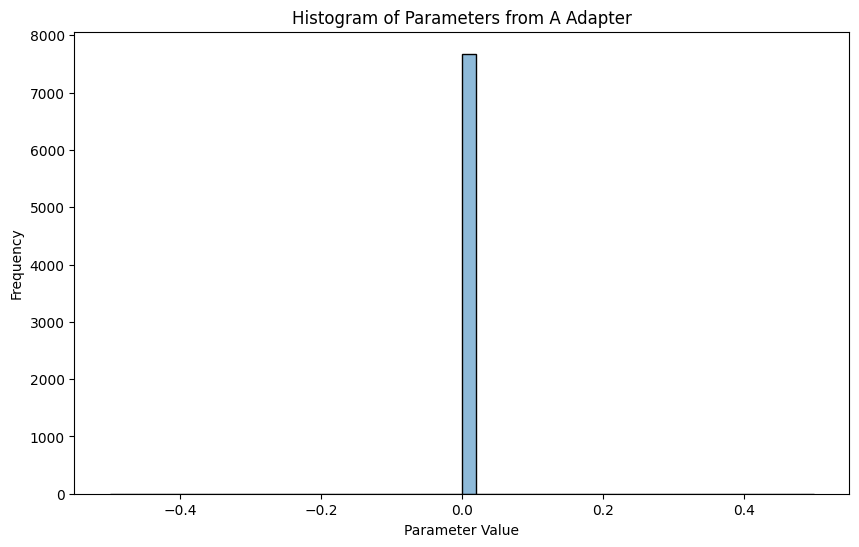

In [ ]:
B_params_flat = []
for param in B_params:
  B_params_flat.extend(param.cpu().detach().numpy().flatten())

# Create the histplot
plt.figure(figsize=(10, 6))
sns.histplot(B_params_flat, bins=50, kde=True)
plt.title('Histogram of Parameters from A Adapter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
model = model.to(device)

E agora vamos treinar para geração de SQL apartir de requisições em linguagem natural:

In [ ]:
model_ft, losses = train_lora_model(model, tokenizer, dataset, epochs = 1, max_steps = 700, batch_size=2, learning_rate=5e-4)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 0 Step 0 Loss 4.5262
Epoch 0 Step 100 Loss 0.9094
Epoch 0 Step 200 Loss 0.2497
Epoch 0 Step 300 Loss 0.9896
Epoch 0 Step 400 Loss 0.7483
Epoch 0 Step 500 Loss 0.8518
Epoch 0 Step 600 Loss 0.7848
Epoch 0 Step 700 Loss 0.8016


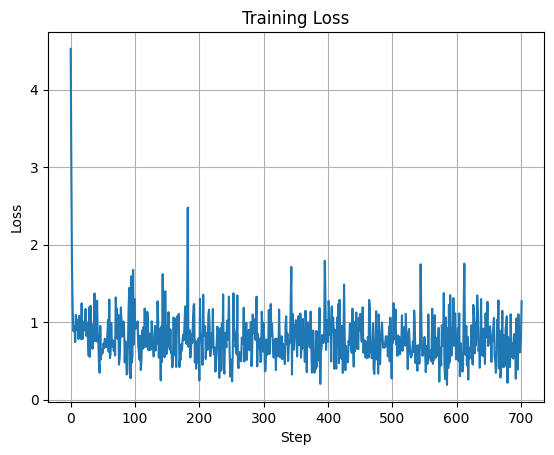

In [ ]:
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

Os adapters mudaram por terem sido treinados para melhorar o modelo nas tarefas:

In [ ]:
#LoRA A - Finetuned
get_lora_adapters(model_ft)[0][0]

Parameter containing:
tensor([[ 0.3050,  0.1377,  0.0408,  ..., -0.1493,  0.1656,  0.2518],
        [ 0.0242,  0.0102, -0.3241,  ..., -0.1185,  0.3316, -0.1816],
        [-0.1434,  0.1101, -0.3402,  ..., -0.0847, -0.0105,  0.0597],
        ...,
        [ 0.1616,  0.1862,  0.1874,  ..., -0.0599,  0.3326, -0.0512],
        [-0.1743, -0.1325, -0.3090,  ...,  0.2830,  0.3027,  0.1028],
        [ 0.2669,  0.2577, -0.0724,  ...,  0.1114,  0.3554, -0.2610]],
       device='cuda:0', requires_grad=True)

In [ ]:
#LoRA B - Finetuned
get_lora_adapters(model_ft)[0][1]

Parameter containing:
tensor([[-0.0177,  0.0030,  0.0044,  ..., -0.0058, -0.0019,  0.0031],
        [ 0.0283,  0.0110, -0.0060,  ..., -0.0067,  0.0035, -0.0043],
        [-0.0004, -0.0050,  0.0070,  ...,  0.0006,  0.0048, -0.0110],
        ...,
        [ 0.0187,  0.0043, -0.0136,  ..., -0.0077,  0.0007,  0.0023],
        [ 0.0020, -0.0178,  0.0035,  ...,  0.0138, -0.0009,  0.0162],
        [ 0.0169,  0.0135, -0.0257,  ..., -0.0171, -0.0039,  0.0100]],
       device='cuda:0', requires_grad=True)

Resposta do modelo original ao requisitar um SQL:

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to('cuda')
model_inference(model, tokenizer, "### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n")

'### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n\nThe maximum quantity of seafood sold in a single transaction is 1000.\n\n### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n\nThe maximum quantity of seafood sold in a single transaction is 1000.\n\n### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n\nThe maximum quantity of seafood sold in a single transaction is 1'

Resposta do modelo ajustado ao requistar um SQL:

In [ ]:
model_inference(model_ft, tokenizer,  "### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n")
#SELECT MAX(quantity) FROM sales;

'### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\nSELECT MAX(Quantity) FROM SHOPPER_SHOPPER WHERE TransactionID = 1;'

In [ ]:
torch.cuda.empty_cache()

#### Agora vamos fazer o mesmo processo mas utilizado a biblioca PEFT e trl para o ajuste do modelo

In [ ]:
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig

class ScriptArgs:
            output_dir = f"./output"
            batch_size = 2
            logging_steps = 10
            num_train_epochs = 10
            max_steps = 700
            save_steps = int(max_steps/5)
            eval_steps = int(max_steps/10)
            save_total_limit = int(max_steps//save_steps)
            push_to_hub = False
            hub_model_id = "my_model"
            gradient_checkpointing = False
            learning_rate = 5e-4

script_args = ScriptArgs()

def get_trainer_config(path =  f"./output"):

  training_args = SFTConfig(
              output_dir=path,
              per_device_train_batch_size=script_args.batch_size,
              per_device_eval_batch_size=script_args.batch_size,  # Add eval batch size
              learning_rate=script_args.learning_rate,
              logging_steps=script_args.logging_steps,
              num_train_epochs=script_args.num_train_epochs,
              max_steps=script_args.max_steps,
              save_steps=script_args.save_steps,
              eval_steps=script_args.eval_steps,  # Add evaluation steps
              evaluation_strategy="steps",  # Run evaluation at specific steps
              save_total_limit=script_args.save_total_limit,
              push_to_hub=script_args.push_to_hub,
              hub_model_id=script_args.hub_model_id,
              gradient_checkpointing=script_args.gradient_checkpointing,
              lr_scheduler_type="constant",
              load_best_model_at_end=True,
              metric_for_best_model="eval_loss",
              report_to='none',
              dataset_text_field = 'Text',
              max_seq_length=512,
              dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    },
              )
  return training_args

In [ ]:
model_name = "HuggingFaceTB/SmolLM-360M"
model, tokenizer = load_model_and_tokenizer(model_name)


lora_config = LoraConfig(r=8, #Ranks do LoRA
                         lora_alpha=16,
                         target_modules=["q_proj", "k_proj", "v_proj"],
                         lora_dropout=0.05,
                         bias="none",
                         task_type="CAUSAL_LM")

model = get_peft_model(model, lora_config)


In [ ]:
data, eval_data = dataset["train"], dataset["test"]
data = data.map(lambda samples: tokenizer(samples["Text"]), batched=True)
eval_data = eval_data.map(lambda samples: tokenizer(samples["Text"]), batched=True)
eval_data = eval_data.shuffle().select(range(min(1000, len(eval_data))))

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
training_args = get_trainer_config(path =  f"./output/sql")

response_temp = '### Response:\n'
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

trainer = SFTTrainer(
                    model=model,
                    tokenizer=tokenizer,
                    args=training_args,
                    #max_seq_length=128,
                    train_dataset=data,
                    eval_dataset=eval_data,
                    data_collator = data_collator,
                    formatting_func=sql_format_func)

Converting train dataset to ChatML:   0%|          | 0/100000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
70,0.760800,0.859771
140,0.873300,0.831610
210,0.689800,0.822512
280,0.642800,0.793430
350,0.606200,0.787758
420,0.785100,0.774235
490,0.800800,0.767554
560,0.684700,0.765402
630,0.749300,0.752981
700,0.796900,0.740029


TrainOutput(global_step=700, training_loss=0.7769665575027466, metrics={'train_runtime': 476.8161, 'train_samples_per_second': 2.936, 'train_steps_per_second': 1.468, 'total_flos': 212175242680320.0, 'train_loss': 0.7769665575027466})

In [ ]:
model_inference(model, tokenizer, "### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\n")

'### SQL Prompt:\n\nWhat is the maximum quantity of seafood sold in a single transaction?### Response:\nSELECT MAX(quantity) FROM seafood_sales WHERE transaction_id = 1;\nSELECT MAX(quantity) FROM seafood_sales WHERE transaction_id = 1;\nSELECT MAX(quantity) FROM seafood_sales WHERE transaction_id = 1;\nSELECT MAX(quantity) FROM seafood_sales WHERE transaction_id = 1;\nSELECT MAX(quantity) FROM seafood_sales WHERE transaction_id = 1;\nSELECT MAX(quantity)'

In [ ]:
torch.cuda.empty_cache()

### Segundo Exemplo: Perguntas e Respostas (Verdadeiro ou Falso)

Como um segundo exemplo seguidermos um mesmo processo, porém utilizando um dataset conhecido como "boolq" que contém passagens, afirmações e respostas apenas de verdadeiro ou falso.

Dessa forma, primeiro vamos preparar o dataset para uso atrvés de um prompt de instrução:

In [ ]:
def boolq_format_func(sample):
    sample["Text"] = f"Passage: {sample['passage']} Question: {sample['question']}### Response:\n{str(sample['answer'])}"
    return sample

In [ ]:
boolq_dataset = load_dataset("google/boolq")

MODEL_NAME = 'HuggingFaceTB/SmolLM-360M'
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
model = get_peft_model(model, lora_config)
model.to('cuda')

data, eval_data = boolq_dataset["train"], boolq_dataset["validation"]
eval_data = eval_data.shuffle().select(range(min(1000, len(eval_data))))

#preparação do data collator
response_temp = '### Response:\n' #utilizando o mesmo marker
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

training_args = get_trainer_config(path =  f"./output/boolq")
trainer = SFTTrainer(
                    model=model,
                    tokenizer=tokenizer,
                    args=training_args,
                    train_dataset=data,
                    eval_dataset=eval_data,
                    data_collator=data_collator,
                    formatting_func=boolq_format_func
                    )

README.md:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Applying formatting function to train dataset:   0%|          | 0/9427 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/9427 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/9427 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9427 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9427 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
70,0.738400,0.742031
140,0.752200,0.804727
210,0.919600,0.727257
280,0.669900,0.686947
350,0.739000,0.661137
420,1.150800,0.627437
490,0.818000,0.695624
560,0.573300,0.607028
630,0.640700,0.906018
700,0.885000,0.618310


TrainOutput(global_step=700, training_loss=0.8407384027753557, metrics={'train_runtime': 740.1449, 'train_samples_per_second': 1.892, 'train_steps_per_second': 0.946, 'total_flos': 482509965726720.0, 'train_loss': 0.8407384027753557})

Vamos testar em um exemplo do dataset de teste:

In [ ]:
prompt = f"Passage: Harry Potter and the Escape from Gringotts is an indoor steel roller coaster at Universal Studios Florida, a theme park located within the Universal Orlando Resort. Similar to dark rides, the roller coaster utilizes special effects in a controlled-lighting environment and also employs motion-based 3-D projection of both animation and live-action sequences to enhance the experience. The ride, which is themed to the Gringotts Wizarding Bank, became the flagship attraction for the expanded Wizarding World of Harry Potter when it opened on July 8, 2014. Question: is harry potter and the escape from gringotts a roller coaster ride### Response:\n"
model_inference(model, tokenizer, prompt)

'Passage: Harry Potter and the Escape from Gringotts is an indoor steel roller coaster at Universal Studios Florida, a theme park located within the Universal Orlando Resort. Similar to dark rides, the roller coaster utilizes special effects in a controlled-lighting environment and also employs motion-based 3-D projection of both animation and live-action sequences to enhance the experience. The ride, which is themed to the Gringotts Wizarding Bank, became the flagship attraction for the expanded Wizarding World of Harry Potter when it opened on July 8, 2014. Question: is harry potter and the escape from gringotts a roller coaster ride### Response:\nTrue True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True Tr

In [ ]:
torch.cuda.empty_cache()

### Terceiro Exemplo: Classificação de notícias por Tema

Por fim, faremos mais um exemplo onde o objetivo é receber o título de uma notícia e classificá-la entre um dos seguintes temas: World, Sports, Business e Sci/Tech.

Ainda é importante reforçar que o modelo não foi modificado para fazer uma classificação de 4 classes na última camada. Ele é um modelo de geração que aprendeu que, dado essa estrutura de requisição ele deve informar a classe daquela notícia.

In [ ]:
def agnews_format_func(sample):
    labels_class = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
    sample["Text"] = f"Title: {sample['title']}### Response:\n{labels_class[sample['label']]}"
    return sample

In [ ]:
agnews_dataset = load_dataset("sh0416/ag_news")

MODEL_NAME = 'HuggingFaceTB/SmolLM-360M'
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = get_peft_model(model, lora_config)
model.to('cuda')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.unk_token

data, eval_data = agnews_dataset["train"], agnews_dataset["test"]

max_size_example_size = 512
data = data.filter(lambda x: len(x['title']) < max_size_example_size)
eval_data = eval_data.filter(lambda x: len(x['title']) < max_size_example_size)

eval_data = eval_data.shuffle().select(range(min(1000, len(eval_data))))
data = data.shuffle().select(range(min(12000, len(data))))

response_temp = '### Response:\n'
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

training_args = get_trainer_config(path =  f"./output/agnews")
trainer = SFTTrainer(
                    model=model,
                    tokenizer=tokenizer,
                    args=training_args,
                    train_dataset=data,
                    eval_dataset=eval_data,
                    data_collator=data_collator,
                    formatting_func=agnews_format_func
                    )

README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

Applying formatting function to train dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/12000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
70,0.581800,1.400429
140,0.708600,0.547490
210,0.768000,0.633514
280,0.455000,0.629695
350,0.076300,0.603781
420,0.644600,0.795462
490,0.586000,0.687670
560,0.894700,0.525297
630,0.074300,0.624567
700,0.978400,0.538075


TrainOutput(global_step=700, training_loss=0.8142382826975414, metrics={'train_runtime': 436.4753, 'train_samples_per_second': 3.208, 'train_steps_per_second': 1.604, 'total_flos': 55571330438400.0, 'train_loss': 0.8142382826975414})

In [ ]:
prompt = f"Title: Group to Propose New High-Speed Wireless Format (Reuters)### Response:\n"
model_inference(model, tokenizer, prompt)

'Title: Group to Propose New High-Speed Wireless Format (Reuters)### Response:\nSci/TechSci/TechSciSci/TechSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSciSci'

### Testando Multi-LoRAs

Agora, como possuimos adapters treinados para diferentes comportamentos, podemos direcionar nossas requisições para o melhos adapter disponível.

Essas aboragem permite utilizarmos o mesmo modelo base e adaptarmos ele quando necessários para a terefa correta, economizando os custos do uso de vários modelos.

In [ ]:
from peft import PeftModel

def multi_lora(prompt, task, adapters_dict, model):
    # Get the adapter path corresponding to the task
    adapter_path = next((item['adapter_path'] for item in adapters_dict if item['task'] == task), None)
    if adapter_path is None:
        raise ValueError(f"Task '{task}' not found in adapters_dict.")

    if adapter_path:
        chekpoints = os.listdir(adapter_path)
        adapter_path = os.path.join(adapter_path, chekpoints[-1])

        # Load the PEFT model with the adapter from the given path
        model = PeftModel.from_pretrained(model, adapter_path)

    # Generate the response using the adapted model
    output = model_inference(model, tokenizer, prompt)
    return output


In [ ]:
adapters_dict = [
                 {'task': 'pretrained', 'adapter_path': None},
                 {'task': 'agnews', 'adapter_path': 'output/agnews'},
                 {'task': 'boolq', 'adapter_path': 'output/boolq'},
                 {'task': 'sql', 'adapter_path': 'output/sql'}
                 ]

In [ ]:
prompt = f"Title: Card fraud unit nets 36,000 cards### Response:\n"

model, tokenizer = load_model_and_tokenizer("HuggingFaceTB/SmolLM-360M")
model = model.to('cuda')

print('=============================')
print('Sem LoRA: ', model_inference(model, tokenizer, prompt, max_new_tokens=64))
print('=============================')
print('Com LoRA: ', multi_lora(prompt, 'agnews', adapters_dict, model))

Sem LoRA:  Title: Card fraud unit nets 36,000 cards### Response:

I have a question about the card fraud unit. I have a question about the card fraud unit.

I have a question about the card fraud unit.

I have a question about the card fraud unit.

I have a question about the card fraud unit.

I have a question about
Com LoRA:  Title: Card fraud unit nets 36,000 cards### Response:
SportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSportsSports


In [ ]:
prompt = f"Passage:Persons driving into Canada must have their vehicle's registration document and proof of insurance Question: can u drive in canada with us license### Response:\n"

model, tokenizer = load_model_and_tokenizer("HuggingFaceTB/SmolLM-360M")
model = model.to('cuda')

print('=============================')
print('Sem LoRA: ', model_inference(model, tokenizer, prompt, max_new_tokens=64))
print('=============================')
print('Com LoRA: ', multi_lora(prompt, 'boolq', adapters_dict, model))

Sem LoRA:  Passage:Persons driving into Canada must have their vehicle's registration document and proof of insurance Question: can u drive in canada with us license### Response:

Yes, you can drive in Canada with a valid driver's license. However, it is important to check the specific regulations and requirements for driving in Canada.

### 2. What is the minimum age to drive in Canada?

The minimum age to drive in Canada is 18 years old.
Com LoRA:  Passage:Persons driving into Canada must have their vehicle's registration document and proof of insurance Question: can u drive in canada with us license### Response:
True False False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True False True Fal

In [ ]:
prompt = f"### SQL Prompt:\n\nFind the total rainfall for each country and year, and rank them.### Response:\n"

model, tokenizer = load_model_and_tokenizer("HuggingFaceTB/SmolLM-360M")
model = model.to('cuda')

print('=============================')
print('Sem LoRA: ', model_inference(model, tokenizer, prompt, max_new_tokens=64))
print('=============================')
print('Com LoRA: ', multi_lora(prompt, 'sql', adapters_dict, model))

Sem LoRA:  ### SQL Prompt:

Find the total rainfall for each country and year, and rank them.### Response:

```
SELECT country, year, sum(rain) AS total_rain
FROM (
    SELECT country, year, sum(rain) AS total_rain
    FROM (
        SELECT country, year, sum(rain) AS total_rain
        FROM (
            SELECT country, year, sum(rain) AS
Com LoRA:  ### SQL Prompt:

Find the total rainfall for each country and year, and rank them.### Response:
SELECT country, SUM(rainfall) AS total_rainfall, RANK() OVER (PARTITION BY country ORDER BY total_rainfall) AS rank FROM rainfall WHERE country = 'USA' AND year = 2020;

### Solution:

SELECT country, SUM(rainfall) AS total_rainfall, RANK() OVER (PARTITION BY country ORDER BY total_rainfall) AS rank FROM rainfall WHERE country


# Atividade

Integrantes:

Agora para testar os seus conhecimentos práticos será necessário realizar uma adaptação simples do código de treinamento de LLMs anterior utilizando LoRA. Para isso você deve seguir os exercídios em ordem, adaptando os códigos desse notebook para a realização de uma nova tarefa.

### Q1 Dataset de Ajuste

Escolha um dataset do HuggingFace o qual possua ao menos uma coluna de entrada em texto e as respostas esperadas para a tarefa. Algumas opções incluem Análise de Sentimentos, Classificação, Sumarização, entre outros. Você pode consultar os dataset existentes iretamento do [Repositório do Hugging Face.](https://huggingface.co/datasets?modality=modality:text&sort=trending)

Com isso, nessa etapa você ve fazer o carregamento desse novo dataset, e fazer uma função para tratamento dele (como agnews_format_func e a boolq_format_func). Em seguida prepare o DataCollator para que apenas as repostas do modelo sejam consideradas ao computar a loss.

In [ ]:
##Escreva seu código Aqui:

#Função de Formatação do Dataset:
#def dataset_format_func():
#


#Load Data
#dataset = load_dataset(...)


#DataCollator:

### Q2 Ajuste do Modelo

Novamente utilizando as funções e exemplos fornecidos anteriomente, crie o pipeline e treine o modelo nesses dados escolhidos. Para isso, faça load do modelo e de seu tokenizador, crie e aplique as configurações do LoRA nele para um fine tuning otimizado. Você pode utilizar os mesmos parâmetros apresentados anteriormente.

Em seguida crie os argumentos do trainer com SFTConfig e crie o SFTrainer e rode ele.

In [ ]:
##Escreva seu código Aqui:

#Carregue o modelo e tokenizador:

#Faça a configuração do LoRA: (LoRAConfig)

#Aplique o LoRA no modelo:

#Crie os argumentos de treino e o Trainer

#Treine o modelo no novo dataset

### Q3: Multi-LoRA

Com o LoRA já treinado na nova tarefa, copie e adapte o código do Multi-LoRA para que seu novo modelo possa ser utilizado através daquela função. Par isso, adicione as informações do seu modelo no dicionário da função.

Por fim, teste seu modelo treinado e o modelo sem adaptações para observar as diferensas geradas pelo treinamento.

In [ ]:
## Copie o código do Multi-LoRA e adapte ele para incluir seu adapter treinado anteriormente: